In [52]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
from IPython.display import clear_output

from models import *
from samplers import * 
from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
prior = torch.distributions.MultivariateNormal(torch.ones(1), 2*torch.eye(1))

N_D = 1000
multiplicity = 10

D_theta = prior.sample([N_D])
D_x = D_theta + torch.randn(N_D, multiplicity)

In [68]:
dif = ConditionalDIF(D_x, D_theta, 2,[64,64])
dif.train(200, lr = 5e-3, verbose = True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:10<00:00, 19.18it/s, loss = 13.802048 ; device: cpu]


In [72]:
N_obs = 100
sigma_misspecification = 2
theta_obs= prior.sample([N_obs])
N_per_obs = 2
x0_obs=[]
for theta in theta_obs: 
    x0_obs.append(theta + torch.randn(N_per_obs, multiplicity)*(1+sigma_misspecification))
x0_obs = torch.stack(x0_obs)
print(x0_obs.shape)

torch.Size([100, 2, 10])


In [73]:
theta_test = torch.tensor([0.])
print(theta_test[0])
x0_test = theta_test + torch.randn(N_per_obs, multiplicity)
print(x0_test.shape)

tensor(0.)
torch.Size([2, 10])


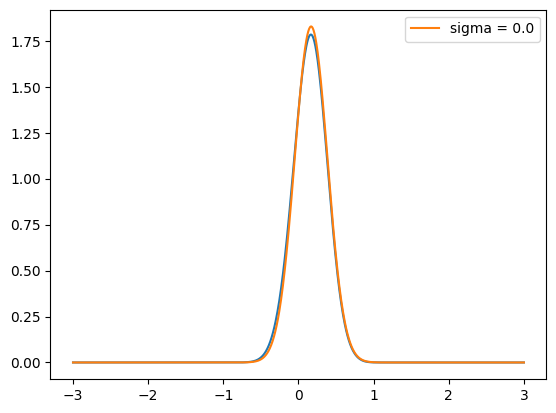

In [74]:
tt = torch.linspace(-3,3,1000)
with torch.no_grad():
    for sigma in torch.linspace(4,0,50):
        noisy_x0 = x0_test + sigma*torch.randn_like(x0_test)
        posterior_log_prob = lambda theta: prior.log_prob(theta) + torch.sum(dif.log_prob(noisy_x0.unsqueeze(0).repeat(theta.shape[0],1,1), theta.unsqueeze(1).repeat(1, noisy_x0.shape[0],1)), dim= 1)
        plot_1d_unormalized_function(lambda theta: torch.exp(posterior_log_prob(theta.unsqueeze(-1))), range = (-3,3), bins = 1000)
        
        sigma2_n = (1 + multiplicity*N_per_obs)**(-1)
        mu_n = sigma2_n*(torch.sum(noisy_x0))
        true_posterior= torch.distributions.MultivariateNormal(torch.tensor([mu_n]), torch.tensor([[sigma2_n]]))
        plt.plot(tt, torch.exp(true_posterior.log_prob(tt.unsqueeze(-1))), label ='sigma = '+ str(sigma.item()))
        plt.legend()
        plt.show()
        clear_output(wait= True)

In [75]:
#joint training
current_dif = dif
for i in tqdm(range(10)):
    current_theta = []
    for x0 in x0_obs:
        posterior_log_prob = lambda theta: prior.log_prob(theta) + torch.sum(dif.log_prob(x0.unsqueeze(1).repeat(1,theta.shape[0],1), theta.unsqueeze(0).repeat(x0.shape[0],1,1)), dim = 0)
        sampler = IMH(posterior_log_prob,1, prior,1)
        current_theta.append(sampler.sample(100))
    D_theta_plus = torch.cat([D_theta, torch.cat(current_theta, dim = 0).repeat_interleave(N_per_obs, dim = 0)], dim = 0)
    D_x_plus = torch.cat([D_x, x0_obs.reshape(N_per_obs*N_obs, multiplicity)], dim =0)
    current_dif = ConditionalDIF(D_x_plus, D_theta_plus,2,[64,64])
    current_dif.train(200, lr = 5e-3)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [09:08<00:00, 54.84s/it]


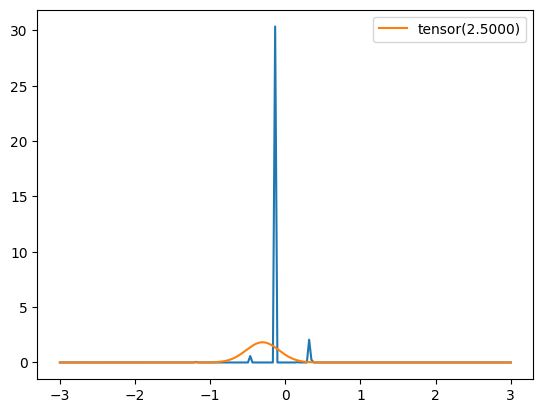

In [10]:
tt = torch.linspace(-3,3,1000)
sigma2_n = (1 + multiplicity*N_per_obs)**(-1)
mu_n = sigma2_n*(torch.sum(x0_test))
true_posterior= torch.distributions.MultivariateNormal(torch.tensor([mu_n]), torch.tensor([[sigma2_n]]))
with torch.no_grad():
    for sigma in torch.linspace(-0.5,2.5,100):
        posterior_log_prob = lambda theta: prior.log_prob(theta) + torch.sum(dif.log_prob(x0_test.unsqueeze(0).repeat(theta.shape[0],1,1)+sigma*torch.randn(theta.shape[0],N_per_obs,multiplicity), theta.unsqueeze(1).repeat(1, x0_test.shape[0],1)), dim= 1)
        plot_1d_unormalized_function(lambda theta: torch.exp(posterior_log_prob(theta.unsqueeze(-1))), range = (-3,3), bins=200)
        plt.plot(tt, torch.exp(true_posterior.log_prob(tt.unsqueeze(-1))), label = str(sigma))
        plt.legend()
        plt.show()
        clear_output(wait= True)